In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# --- Load Data ---
ref_df = pd.read_csv("reference_v2.csv")
mix_df = pd.read_csv("mixtures_dataset.csv")
query_df = pd.read_csv("query_only_mixed.csv")

crop_max = 1700

# --- Preprocessing Functions ---
def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D @ D.T
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr, lam=1e4, p=0.01, niter=10):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec, lam=lam, p=p, niter=niter)
        corr = spec - bkg
        normed = corr / np.linalg.norm(corr) if np.linalg.norm(corr) else corr
        out[i] = np.abs(normed)
    return out

def extract_cps(spectra, num_peaks=15, height=0.01, prominence=0.01):
    counts = np.zeros(spectra.shape[1])
    for spec in spectra:
        peaks, _ = find_peaks(spec, height=height, prominence=prominence)
        counts[peaks] += 1
    top_peaks = np.argsort(counts)[-num_peaks:]
    return sorted(top_peaks)

def elastic_net_nnls(A, b, alpha=0.001, l1_ratio=0.5):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True, max_iter=10000)
    model.fit(A, b)
    return model.coef_

# --- Prepare Reference ---
all_cols = ref_df.columns.drop("Label")
wavenumbers = pd.to_numeric(all_cols, errors="coerce")
valid_cols = all_cols[wavenumbers < crop_max]

ref_data = ref_df[valid_cols].values
ref_labels = ref_df["Label"].values
X_ref = preprocess(ref_data)

# Reference average per class
classes = np.unique(ref_labels)
ref_spectra_avg = {c: X_ref[ref_labels == c].mean(axis=0) for c in classes}
ref_matrix = np.array([ref_spectra_avg[c] for c in classes])

# Extract CPs
cps = extract_cps(X_ref, num_peaks=15)
ref_matrix_cps = ref_matrix[:, cps]

# --- Prepare Mixture Dataset ---
mix_data = mix_df[valid_cols].values
X_mix = preprocess(mix_data)
X_mix_cps = X_mix[:, cps]

# Ground truth binary matrix
y_mix = np.array([[chem in (l1, l2) for chem in classes]
                  for l1, l2 in zip(mix_df["Label 1"], mix_df["Label 2"])])

# Train/test split (50/50) on mixture data
X_train, X_test, y_train, y_test = train_test_split(X_mix_cps, y_mix, test_size=0.5, random_state=42)

# Convert to weights using ElasticNet
weights_train = np.array([elastic_net_nnls(ref_matrix_cps.T, x) for x in X_train])
weights_test  = np.array([elastic_net_nnls(ref_matrix_cps.T, x) for x in X_test])

# --- Train Meta-Classifiers ---
meta_models = {}
for i, chem in enumerate(classes):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(weights_train, y_train[:, i])
    meta_models[chem] = clf

# --- Internal Evaluation on 50% Mixture Test Set ---
proba_test = np.array([meta_models[c].predict([w])[0] for w in weights_test for c in classes])
proba_test = proba_test.reshape(len(weights_test), len(classes))
binary_test = (proba_test > 0.5).astype(int)

test_metrics = {}
for i, chem in enumerate(classes):
    acc = accuracy_score(y_test[:, i], binary_test[:, i])
    prec = precision_score(y_test[:, i], binary_test[:, i], zero_division=0)
    rec = recall_score(y_test[:, i], binary_test[:, i], zero_division=0)
    test_metrics[chem] = {"Accuracy": acc, "Precision": prec, "Recall": rec}

print("Internal Test Metrics on mixtures_dataset.csv")
print(pd.DataFrame.from_dict(test_metrics, orient="index"))

# --- Final Validation on query_only_mixed.csv ---
query_data = query_df[valid_cols].values
X_query = preprocess(query_data)
X_query_cps = X_query[:, cps]

weights_query = np.array([elastic_net_nnls(ref_matrix_cps.T, x) for x in X_query_cps])

proba_preds = np.array([meta_models[c].predict([w])[0] for w in weights_query for c in classes])
proba_preds = proba_preds.reshape(len(weights_query), len(classes))
binary_preds = (proba_preds > 0.5).astype(int)

# Build predicted labels
predicted_labels = []
for i, row in enumerate(binary_preds):
    if row.sum() == 0:
        row[np.argmax(proba_preds[i])] = 1
    predicted_labels.append([classes[j] for j in range(len(classes)) if row[j]])

# Evaluate accuracy on query_only_mixed.csv
true1 = query_df["Label 1"].values
true2 = query_df["Label 2"].values
results_df = pd.DataFrame({"True1": true1, "True2": true2, "Predicted": predicted_labels})

def compute_total_accuracy(results_df):
    correct = 0
    total = len(results_df)
    for _, row in results_df.iterrows():
        true1, true2, pred = row["True1"], row["True2"], row["Predicted"]
        if pd.isna(true2):
            if true1 in pred and len(pred) == 1:
                correct += 1
        else:
            if true1 in pred and true2 in pred and len(pred) == 2:
                correct += 1
    return correct / total

val_accuracy = compute_total_accuracy(results_df)
print("\n Final Validation Accuracy on query_only_mixed.csv:", val_accuracy)
print(results_df)




Internal Test Metrics on mixtures_dataset.csv
                              Accuracy  Precision    Recall
1,9-nonanedithiol             1.000000        0.0  0.000000
1-dodecanethiol               1.000000        1.0  1.000000
1-undecanethiol               1.000000        0.0  0.000000
6-mercapto-1-hexanol          0.920690        1.0  0.603448
benzene                       1.000000        1.0  1.000000
benzenethiol                  0.931034        1.0  0.500000
dmmp                          1.000000        0.0  0.000000
etoh                          1.000000        1.0  1.000000
meoh                          0.934483        1.0  0.834783
n,n-dimethylformamide         1.000000        1.0  1.000000
pyridine                      1.000000        1.0  1.000000
tris(2-ethylhexyl) phosphate  1.000000        0.0  0.000000

 Final Validation Accuracy on query_only_mixed.csv: 0.8333333333333334
                    True1                 True2  \
0    6-mercapto-1-hexanol               benzene   


In [64]:
# Ground truth binary matrix for query_only_mixed.csv
y_query_true = np.array([[chem in (l1, l2) for chem in classes]
                         for l1, l2 in zip(query_df["Label 1"], query_df["Label 2"])])

# Print classification report for test set
print("\n--- Classification Report: Test Set (mixtures_dataset.csv) ---")
report_test = classification_report(y_test, binary_test, target_names=classes, zero_division=0)
print(report_test)

# Print classification report for validation set
print("\n--- Classification Report: Validation Set (query_only_mixed.csv) ---")
report_val = classification_report(y_query_true, binary_preds, target_names=classes, zero_division=0)
print(report_val)



--- Classification Report: Test Set (mixtures_dataset.csv) ---
                              precision    recall  f1-score   support

           1,9-nonanedithiol       0.00      0.00      0.00         0
             1-dodecanethiol       1.00      1.00      1.00       120
             1-undecanethiol       0.00      0.00      0.00         0
        6-mercapto-1-hexanol       1.00      0.60      0.75        58
                     benzene       1.00      1.00      1.00       106
                benzenethiol       1.00      0.50      0.67        40
                        dmmp       0.00      0.00      0.00         0
                        etoh       1.00      1.00      1.00        58
                        meoh       1.00      0.83      0.91       115
       n,n-dimethylformamide       1.00      1.00      1.00        30
                    pyridine       1.00      1.00      1.00        53
tris(2-ethylhexyl) phosphate       0.00      0.00      0.00         0

                   micro

In [65]:
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split, KFold

In [66]:
all_cols = ref_df.columns.drop("Label")
wavenumbers = pd.to_numeric(all_cols, errors="coerce")
valid_cols = all_cols[wavenumbers < crop_max]

ref_data = ref_df[valid_cols].values
ref_labels = ref_df["Label"].values
X_ref = preprocess(ref_data)

classes = np.unique(ref_labels)
ref_spectra_avg = {c: X_ref[ref_labels == c].mean(axis=0) for c in classes}
ref_matrix = np.array([ref_spectra_avg[c] for c in classes])
cps = extract_cps(X_ref, num_peaks=15)
ref_matrix_cps = ref_matrix[:, cps]

# --- Prepare Mixtures ---
mix_data = mix_df[valid_cols].values
X_mix = preprocess(mix_data)
X_mix_cps = X_mix[:, cps]
y_mix = np.array([[chem in (l1, l2) for chem in classes]
                  for l1, l2 in zip(mix_df["Label 1"], mix_df["Label 2"])])

indices = np.arange(len(X_mix_cps))
train_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=42)
X_train, X_test = X_mix_cps[train_idx], X_mix_cps[test_idx]
y_train, y_test = y_mix[train_idx], y_mix[test_idx]

weights_train = np.array([elastic_net_nnls(ref_matrix_cps.T, x) for x in X_train])




Grid Search: 100%|██████████| 24/24 [00:00<00:00, 12859.39it/s]



Best Parameters:
alpha = 0.0001, l1_ratio = 0.5, accuracy = 1.0000


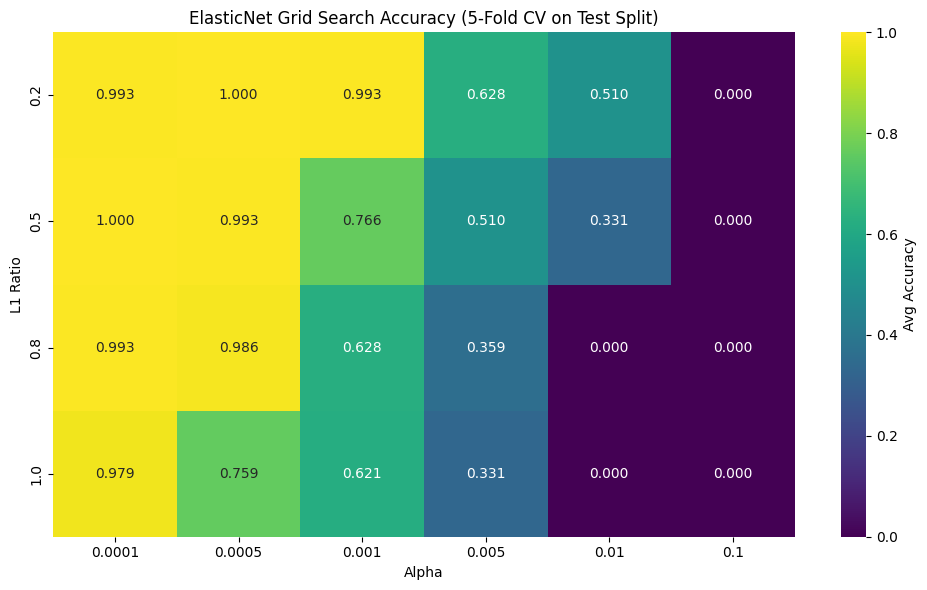

In [ ]:
# --- Define Hyperparameter Grid ---
alphas = [1e-4, 0.5e-3, 1e-3, 0.5e-2]
l1_ratios = [0.2, 0.5, 0.8, 1.0]
grid = list(itertools.product(alphas, l1_ratios))

# --- Define accuracy metric ---
def compute_total_accuracy(results_df):
    correct = 0
    total = len(results_df)
    for _, row in results_df.iterrows():
        true1, true2, pred = row["True1"], row["True2"], row["Predicted"]
        if pd.isna(true2):
            if true1 in pred and len(pred) == 1:
                correct += 1
        else:
            if true1 in pred and true2 in pred and len(pred) == 2:
                correct += 1
    return correct / total

# --- Define parallel grid search function ---
def evaluate_combo(alpha, l1_ratio, X_test, y_test, ref_matrix_cps, mix_df, test_idx, classes, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    fold_scores = []

    for train_cv_idx, val_cv_idx in kf.split(X_test):
        X_fold_train = X_test[train_cv_idx]
        y_fold_train = y_test[train_cv_idx]
        X_fold_val = X_test[val_cv_idx]
        y_fold_val = y_test[val_cv_idx]

        weights_train = np.array([elastic_net_nnls(ref_matrix_cps.T, x, alpha=alpha, l1_ratio=l1_ratio) for x in X_fold_train])
        weights_val = np.array([elastic_net_nnls(ref_matrix_cps.T, x, alpha=alpha, l1_ratio=l1_ratio) for x in X_fold_val])

        meta_models = {}
        for i, chem in enumerate(classes):
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(weights_train, y_fold_train[:, i])
            meta_models[chem] = clf

        proba_preds = np.array([
            meta_models[c].predict([w])[0]
            for w in weights_val
            for c in classes
        ])
        proba_preds = proba_preds.reshape(len(weights_val), len(classes))
        binary_preds = (proba_preds > 0.5).astype(int)
        predicted_labels = [[classes[j] for j in range(len(classes)) if row[j]] for row in binary_preds]

        fold_df = pd.DataFrame({
            "True1": mix_df.iloc[test_idx[val_cv_idx]]["Label 1"].values,
            "True2": mix_df.iloc[test_idx[val_cv_idx]]["Label 2"].values,
            "Predicted": predicted_labels
        })

        acc = compute_total_accuracy(fold_df)
        fold_scores.append(acc)

    mean_score = np.mean(fold_scores)
    return (alpha, l1_ratio, mean_score)

# --- Run Parallel Grid Search ---
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combo)(alpha, l1_ratio, X_test, y_test, ref_matrix_cps, mix_df, test_idx, classes)
    for alpha, l1_ratio in tqdm(grid, desc="Grid Search")
)

# --- Find best params ---
results_df = pd.DataFrame(results, columns=["alpha", "l1_ratio", "avg_accuracy"])
best_row = results_df.loc[results_df["avg_accuracy"].idxmax()]
best_params = (best_row["alpha"], best_row["l1_ratio"])
best_score = best_row["avg_accuracy"]

print("\nBest Parameters:")
print(f"alpha = {best_params[0]}, l1_ratio = {best_params[1]}, accuracy = {best_score:.4f}")

# --- Plot Heatmap ---
pivot = results_df.pivot(index="l1_ratio", columns="alpha", values="avg_accuracy")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label": "Avg Accuracy"})
plt.title("ElasticNet Grid Search Accuracy (5-Fold CV on Test Split)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()